### 데이터 구성

- 데이터를 직접 생성합니다

In [14]:
import numpy as np

np.random.seed(seed = 1)
N = 1000 #데이터 개수
K = 3

y = np.zeros((N,3),dtype = np.uint8)
x = np.zeros((N,2))

Mu = np.array([[-2.0,-2.0], [1.5,2.0], [2.0,-1.5]])
Sig = np.array([[.9,.9],[.8,.7],[.9,1.0]])
Pi = np.array([0.35, 0.7, 1.0])

for n in range(N):
  wk = np.random.rand()
  for k in range(K):
    if wk < Pi[k]:
      y[n,k] = 1
      break

  for k in range(2):
    x[n,k] = np.random.randn()*Sig[ y[n,:] == 1, k] + Mu[y[n, :] == 1, k]

- train, test, validation 데이터를 구분합니다

In [26]:
train_rate = 600
test_rate = 200

x_train, x_test, x_validation = x[:train_rate,:], x[train_rate: train_rate + test_rate,:], x[train_rate + test_rate:, :]
y_train, y_test, y_validation = y[:train_rate,:], y[train_rate: train_rate + test_rate,:], y[train_rate + test_rate:, :]

print(y_train.shape, y_test.shape, y_validation.shape)

(600, 3) (200, 3) (200, 3)


 ### 은닉층의 node 수를 8개(P=8)로 하여 구현하기.
 

In [27]:
def Sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y

In [28]:
def FNN(w, H, O, x): #w: 가중치 행렬(flatten), H : 히든노드 개수, O : 출력노드 개수, x: 입력벡터
  n,d = x.shape #입력 데이터 개수와 차원 할당.
  #가중치 분배
  w1 = w[:H*(d+1)]
  w1 = w1.reshape(H,(d+1))
  w2 = w[H*(d+1):]
  w2 = w2.reshape(O,(H+1))

  #zsum, z, osum, o 정의
  zsum = np.zeros((n, H+1))
  z = np.zeros((n, H+1))
  osum = np.zeros((n,O))
  o = np.zeros((n,O))

  for k in range(n):
    #U1층과 U2층에 대한 출력노드 값 계산
    for j in range(H):
      #k번째 데이터값에 대한 zsum,z
      zsum[k, j] = np.dot(w1[j, :], np.r_[ x[k, :], 1 ])
      z[k,j] = Sigmoid(zsum[k,j])

    z[k,H] = 1 #더미 뉴런 생성
    for c in range(O):
      #k번째 데이터값에 대한 osum,o
      osum[k, c] = np.dot(w2[c, :], z[k, :])
      o[k,c] = Sigmoid(osum[k,c])
  
  return o, osum, z, zsum

W = np.ones(51)
P = 8 #히든노드 개수
C = 3 # 
FNN(W, P, C, x_train[:2, :])

(array([[0.99984552, 0.99984552, 0.99984552],
        [0.7489787 , 0.7489787 , 0.7489787 ]]),
 array([[8.77532317, 8.77532317, 8.77532317],
        [1.09317277, 1.09317277, 1.09317277]]),
 array([[0.9719154, 0.9719154, 0.9719154, 0.9719154, 0.9719154, 0.9719154,
         0.9719154, 0.9719154, 1.       ],
        [0.0116466, 0.0116466, 0.0116466, 0.0116466, 0.0116466, 0.0116466,
         0.0116466, 0.0116466, 1.       ]]),
 array([[ 3.54404726,  3.54404726,  3.54404726,  3.54404726,  3.54404726,
          3.54404726,  3.54404726,  3.54404726,  0.        ],
        [-4.44102634, -4.44102634, -4.44102634, -4.44102634, -4.44102634,
         -4.44102634, -4.44102634, -4.44102634,  0.        ]]))

### 은닉층과 출력층의 활성화 함수 : sigmoid 함수, 목적함수 : MSE(Mean Square Error)

In [29]:
def MSE(w,H,O,x,t):
  n,d = x.shape
  o,_,_,_ = FNN(w,H,O,x)
  mse = np.sum((t.reshape(-1) - o.reshape(-1))**2)/n
  return mse

W = np.ones(51)
P = 8
C = 3
MSE(W, P, C, x_train[:2, :], y_train[:2, :])

1.5921660305753165

### 다층 퍼셉트론 학습을 위한 미니배치 스톡 캐스트 경사 하강법(Mini-batch Stochastic Gradient Decent Method)를 구현하기. 
  - 해당 함수 이름 :trainingMLP
  - batch 크기를 8, 16, 32개로 변경하면서 실험을 통해 좋은 성능의 batch 크기 찾아보기.
  - stop 조건으로 epoch 반복 횟수로 정하기. epoch는 학습진행 정도를 관찰하여 결정.
  - 알고리즘 수행 중에 1 epoch 마다 검증 데이터셋(validation set)을 사용하여 학습 중 가중치의 성능을 평가하고, 1 epoch마다 training set과 validation set를 사용 한 MSE 에러값, 정확도(accuracy), 수행시간을 화면에 출력하기.
  - 함수의 반환값은 매 epoch마다 주어진 training set과 validation set의 MSE의 에러값의 history, 그리고 최적 매개변수 가중치 값를 반환.

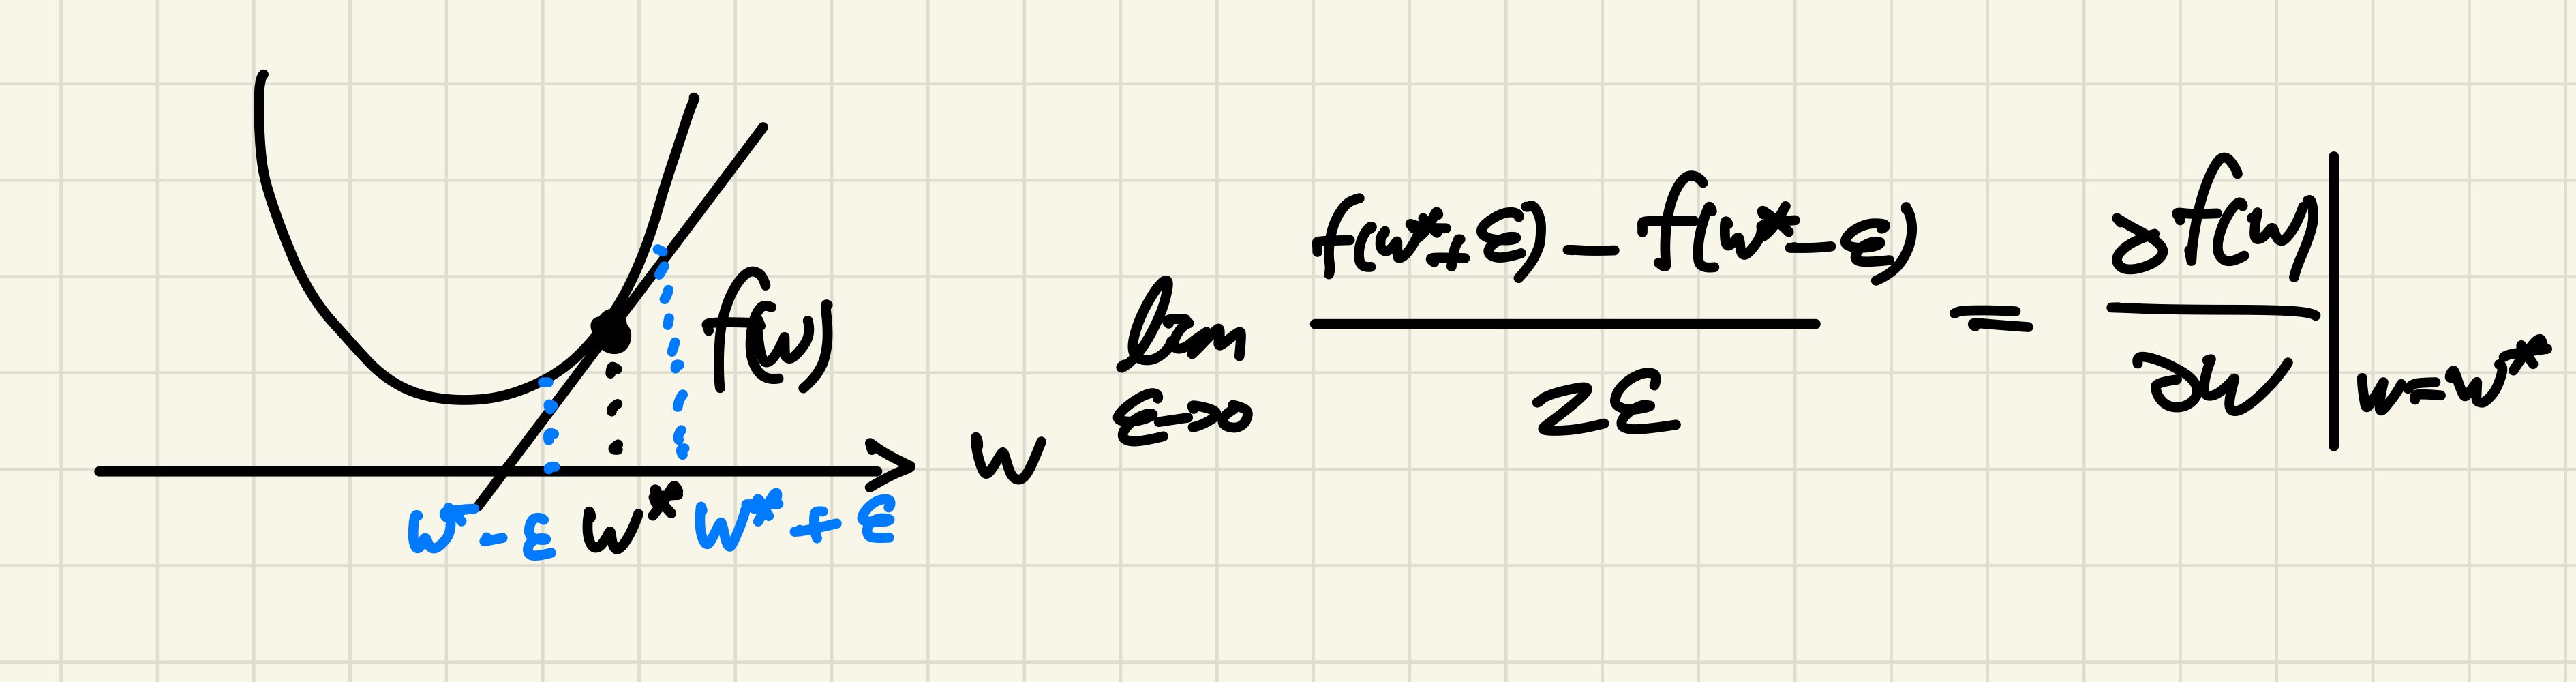

In [30]:
def dMSE(w,H,O,x,t):
  esp = 0.001
  dw = np.zeros_like(w)
  modified_w = w.copy()
  for iw in range(len(w)):
    #도함수 표현 : 그림 참고
    modified_w[iw] = w[iw] - esp
    mse1 = MSE(modified_w,H,O,x,t)
    modified_w[iw] = w[iw] + esp
    mse2 = MSE(modified_w, H,O, x, t)
    dw[iw] = (mse2-mse1) / (2*esp)
  return dw

P = 8
C = 3
nW = P * 3 + C * (P + 1)
np.random.seed(1)
W = np.random.normal(0, 1, nW)
dW = dMSE(W, P, C, x_train[:2, :], y_train[:2, :])
dW

array([ 0.04510116,  0.05544704, -0.01501292,  0.01033712,  0.0385283 ,
        0.04922451, -0.0047297 , -0.00462128,  0.00401646,  0.00581039,
        0.01100997,  0.0059509 , -0.0101403 , -0.01303245,  0.00235491,
       -0.04903966, -0.0515152 ,  0.03506509, -0.04418175, -0.0668066 ,
       -0.01075885,  0.00298833,  0.00672897,  0.00523458, -0.00053181,
       -0.01175033, -0.01027532,  0.00956706, -0.13016355, -0.13205351,
        0.0014085 ,  0.01648044, -0.12843632, -0.0467546 , -0.00326804,
       -0.05458888, -0.06607752,  0.07418957,  0.12189154, -0.05087834,
       -0.1147216 ,  0.02640981,  0.07124889,  0.02771939,  0.10191486,
        0.08062974,  0.14125683,  0.0732962 ,  0.07361914,  0.14016607,
        0.20947639])

In [32]:
import time
import numpy as np

def trainingMLP(w_init, P, C, x_train, t_train, x_valid, t_valid, n, alpha, batch_size):
    wt = w_init
    err_train_hist = []
    err_valid_hist = []
    w_hist = []
    num_batches = len(x_train) // batch_size
    epsilon = 0.001

    for epoch in range(n):
        for batch in range(num_batches):
            start = batch * batch_size
            end = (batch + 1) * batch_size
            x_batch = x_train[start:end]
            t_batch = t_train[start:end]
            wt = wt - alpha * dMSE(wt, P, C, x_batch, t_batch)
        err_train = MSE(wt, P, C, x_train, t_train)
        err_valid = MSE(wt, P, C, x_valid, t_valid)
        # acc_train = MSE(wt, P, C, x_train, t_train)
        # acc_valid = MSE(wt, P, C, x_valid, t_valid)
        err_train_hist.append(err_train)
        err_valid_hist.append(err_valid)
        w_hist.append(wt)
        
        print("Epoch {}/{} - Training MSE: {:.4f}, Training Acc: {:.4f}, Validation MSE: {:.4f}, Validation Acc: {:.4f}".format(epoch, n, err_train, 1-err_train, err_valid, 1- err_valid))
    return err_train_hist, err_valid_hist, w_hist, wt

np.random.seed(1)
P = 8
C = 3
W_init = np.random.normal(0, 0.01, P * 3 + C * (P + 1))
N_epochs = 10
alpha = 0.5
batch_sizes = [8, 16, 32] # Experiment with different batch sizes
for batch_size in batch_sizes:
  print("Batch size: {}".format(batch_size))
  start_time = time.time()
  err_train_hist, err_valid_hist, w_hist, W_opt = trainingMLP(W_init, P, C, x_train, y_train, x_validation, y_validation, N_epochs, alpha, batch_size)
  calculation_time = time.time() - start_time
  print("Execution time: {:.3f} sec".format(calculation_time))
  print("Optimal weight values: ", W_opt)
  print("Training MSE history: ", err_train_hist)
  print("Validation MSE history: ", err_valid_hist)


Batch size: 8
Epoch 0/10 - Training MSE: 0.4751, Training Acc: 0.5249, Validation MSE: 0.4654, Validation Acc: 0.5346
Epoch 1/10 - Training MSE: 0.2181, Training Acc: 0.7819, Validation MSE: 0.2119, Validation Acc: 0.7881
Epoch 2/10 - Training MSE: 0.0912, Training Acc: 0.9088, Validation MSE: 0.0909, Validation Acc: 0.9091
Epoch 3/10 - Training MSE: 0.0604, Training Acc: 0.9396, Validation MSE: 0.0630, Validation Acc: 0.9370
Epoch 4/10 - Training MSE: 0.0487, Training Acc: 0.9513, Validation MSE: 0.0530, Validation Acc: 0.9470
Epoch 5/10 - Training MSE: 0.0426, Training Acc: 0.9574, Validation MSE: 0.0482, Validation Acc: 0.9518
Epoch 6/10 - Training MSE: 0.0389, Training Acc: 0.9611, Validation MSE: 0.0454, Validation Acc: 0.9546
Epoch 7/10 - Training MSE: 0.0364, Training Acc: 0.9636, Validation MSE: 0.0435, Validation Acc: 0.9565
Epoch 8/10 - Training MSE: 0.0346, Training Acc: 0.9654, Validation MSE: 0.0423, Validation Acc: 0.9577
Epoch 9/10 - Training MSE: 0.0332, Training Acc: 0

### trainingMLP’함수 수행 후 반환되는 training set과 validation set의 MSE의 에러 값의 history의 변환 추이

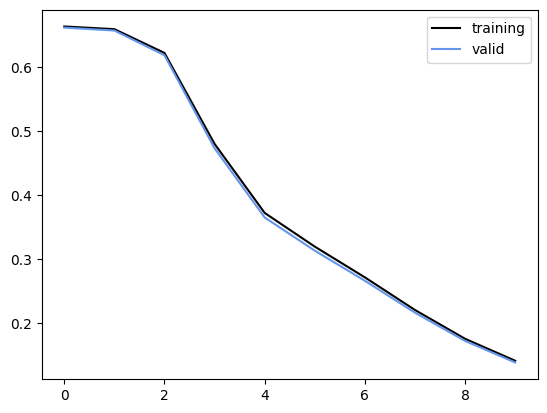

In [11]:
import matplotlib.pyplot as plt
plt.plot(err_train_hist, 'black', label='training')
plt.plot(err_valid_hist, 'cornflowerblue', label ='valid')
plt.legend()
plt.show() #validation dataset을 활용

### trainingMLP’함수 수행 후 반환되는 가중치를 이용하여 새로운 입력인 test set에 관한 성능평가를 수행하여 정확도(accuracy)를 계산하기

In [37]:
predit,_,_,_ = FNN(W_opt, P, C, x_test)
correct = 0
i=0
for o,t in zip(predit,y_test):
    print(f"output[{i}]:{o.argmax(0)} <--> target[{i}]:{t.argmax(0)}")
    correct += (o.argmax(0) == t.argmax(0)).sum().item()
    i=i+1
print(f"Accuracy:{(correct/y_test.shape[0])*100:0.2f}%")

output[0]:2 <--> target[0]:2
output[1]:0 <--> target[1]:0
output[2]:1 <--> target[2]:1
output[3]:2 <--> target[3]:2
output[4]:2 <--> target[4]:2
output[5]:1 <--> target[5]:1
output[6]:0 <--> target[6]:0
output[7]:1 <--> target[7]:1
output[8]:1 <--> target[8]:1
output[9]:1 <--> target[9]:1
output[10]:1 <--> target[10]:1
output[11]:0 <--> target[11]:0
output[12]:0 <--> target[12]:0
output[13]:1 <--> target[13]:1
output[14]:0 <--> target[14]:0
output[15]:1 <--> target[15]:1
output[16]:1 <--> target[16]:1
output[17]:0 <--> target[17]:0
output[18]:0 <--> target[18]:0
output[19]:1 <--> target[19]:1
output[20]:1 <--> target[20]:1
output[21]:1 <--> target[21]:1
output[22]:1 <--> target[22]:1
output[23]:1 <--> target[23]:1
output[24]:0 <--> target[24]:0
output[25]:1 <--> target[25]:1
output[26]:2 <--> target[26]:2
output[27]:0 <--> target[27]:0
output[28]:1 <--> target[28]:2
output[29]:2 <--> target[29]:2
output[30]:1 <--> target[30]:1
output[31]:1 <--> target[31]:1
output[32]:1 <--> target[32]